In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Load dataset
df = pd.read_excel("in_chemico_dataset_processed.xlsx", sheet_name="Descriptors-Fingerprints")

In [27]:
# Prepare X, y
y = df["Phototoxicity"]
# Вибираємо лише числові стовпці (без текстових)
X = df.select_dtypes(include=[np.number]).drop(columns=["Phototoxicity"], errors="ignore")

print(f"Shapes: X={X.shape}, y={y.shape}")

Shapes: X=(162, 218), y=(162,)


In [28]:
corr = X.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop = [c for c in upper.columns if any(upper[c] > 0.9)]
X = X.drop(columns=to_drop)
print(f"Reduced shape after removing correlated: {X.shape}")

Reduced shape after removing correlated: (162, 176)


In [29]:
# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
rf = RandomForestClassifier(n_estimators=300, class_weight='balanced', random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
print("Accuracy (balanced RF):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Accuracy (balanced RF): 0.696969696969697
              precision    recall  f1-score   support

           0       0.65      0.73      0.69        15
           1       0.75      0.67      0.71        18

    accuracy                           0.70        33
   macro avg       0.70      0.70      0.70        33
weighted avg       0.70      0.70      0.70        33




Top 10 features:


PEOE_VSA8            0.044915
MaxAbsEStateIndex    0.029120
MolWt                0.024476
SMR_VSA10            0.022704
AvgIpc               0.020888
Ipc                  0.020741
SMR_VSA3             0.018668
SMR_VSA7             0.017913
BCUT2D_MWLOW         0.017475
EState_VSA3          0.017391
dtype: float64

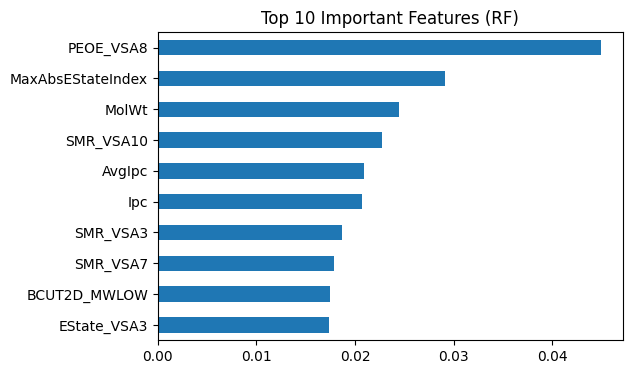

In [31]:
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\nTop 10 features:")
display(importances.head(10))

plt.figure(figsize=(6,4))
importances.head(10).plot(kind='barh')
plt.title("Top 10 Important Features (RF)")
plt.gca().invert_yaxis()
plt.show()

In [32]:
# Grid Search for Iprovment RF
params = {
    'n_estimators': [200, 400, 600],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2']
}

grid = GridSearchCV(RandomForestClassifier(class_weight='balanced', random_state=42, n_jobs=-1),
                    params, cv=5, scoring='accuracy', n_jobs=-1)
grid.fit(X, y)
print("Best RF params:", grid.best_params_)
print("Best cross-val accuracy:", grid.best_score_)

best_rf = grid.best_estimator_

Best RF params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Best cross-val accuracy: 0.6660984848484849


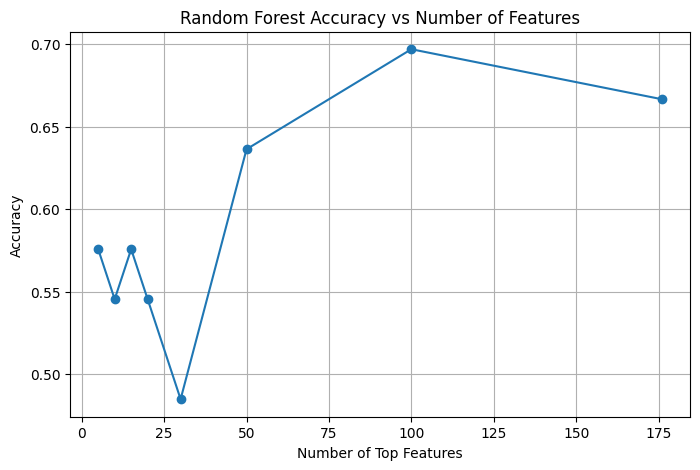

✅ Optimal number of features: 100 (Accuracy=0.697)


In [33]:
results_topn = {}
for n in [5, 10, 15, 20, 30, 50, 100, len(importances)]:
    top_feats = importances.head(n).index
    X_train_n = X_train[top_feats]
    X_test_n = X_test[top_feats]
    model = best_rf
    model.fit(X_train_n, y_train)
    pred = model.predict(X_test_n)
    acc = accuracy_score(y_test, pred)
    results_topn[n] = acc

plt.figure(figsize=(8,5))
plt.plot(list(results_topn.keys()), list(results_topn.values()), marker='o')
plt.xlabel("Number of Top Features")
plt.ylabel("Accuracy")
plt.title("Random Forest Accuracy vs Number of Features")
plt.grid(True)
plt.show()

best_n = max(results_topn, key=results_topn.get)
print(f"✅ Optimal number of features: {best_n} (Accuracy={results_topn[best_n]:.3f})")